# Conditional Logit Model

Consider a scenario where individuals must choose among $K$ mutually exclusive alternatives. The goal is to understand:
- What factors influence choice?
- How do different features affect decision-making?

### Random Utility

For each alternative $j$, define utility $U_{ij}$ for individual $i$:

$$U_{ij} = V_{ij} + \epsilon_{ij}$$

Where:
- $V_{ij} = \beta^T X_{ij}$: Systematic utility (linear function of features)
- $\beta$: Vector of coefficients
- $X_{ij}$: Feature vector for alternative $j$
- $\epsilon_{ij}$: Random error term (Type I Extreme Value distributed)

## Key Assumptions

1. Independence of Irrelevant Alternatives
2. Linearity of utility function
3. IID Gumbel errors

### Conditional Choice Probability

Probability of choosing alternative $j$:

$$P(j|X) = \frac{\exp(V_{ij})}{\sum_{k=1}^K \exp(V_{ik})}$$

## Estimation Algorithm: Maximum Likelihood

### Objective Function

Minimize negative log-likelihood:

$$\mathcal{L}(\beta) = -\sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \log(P(j|X_i))$$

Where:
- $y_{ij}$: Choice indicator (1 if chosen, 0 otherwise)
- $N$: Number of observations

### Optimization Loop

1. Initialize $\beta = \vec{0}$
2. Compute gradient $\nabla \mathcal{L}(\beta)$
3. Use L-BFGS-B to minimize $\mathcal{L}(\beta)$

## Bootstrap Validation

1. Resample data with replacement
2. Reestimate $\hat{\beta}$ for each resample
3. Analyze sampling distribution of $\hat{\beta}$

Dataset Information:
Sample Size: 1000
Number of Alternatives: 3
Number of Features: 5
True Coefficients: [-0.14342322 -0.0326559   0.06429488  0.94686146 -0.74721731]

Model Estimation Results:
Coefficient  Estimate  Std Error  t Statistic  p Value  95% CI Lower  95% CI Upper
  Feature_0 -0.135426   0.044869    -3.018257 0.002607     -0.223475     -0.047378
  Feature_1 -0.066315   0.044932    -1.475908 0.140285     -0.154487      0.021857
  Feature_2  0.094505   0.045168     2.092313 0.036663      0.005870      0.183139
  Feature_3  0.932593   0.056793    16.420784 0.000000      0.821144      1.044041
  Feature_4 -0.717467   0.053586   -13.389015 0.000000     -0.822622     -0.612312

Log-Likelihood: -813.8681640625
Convergence: Successful

Performing Bootstrap Validation...


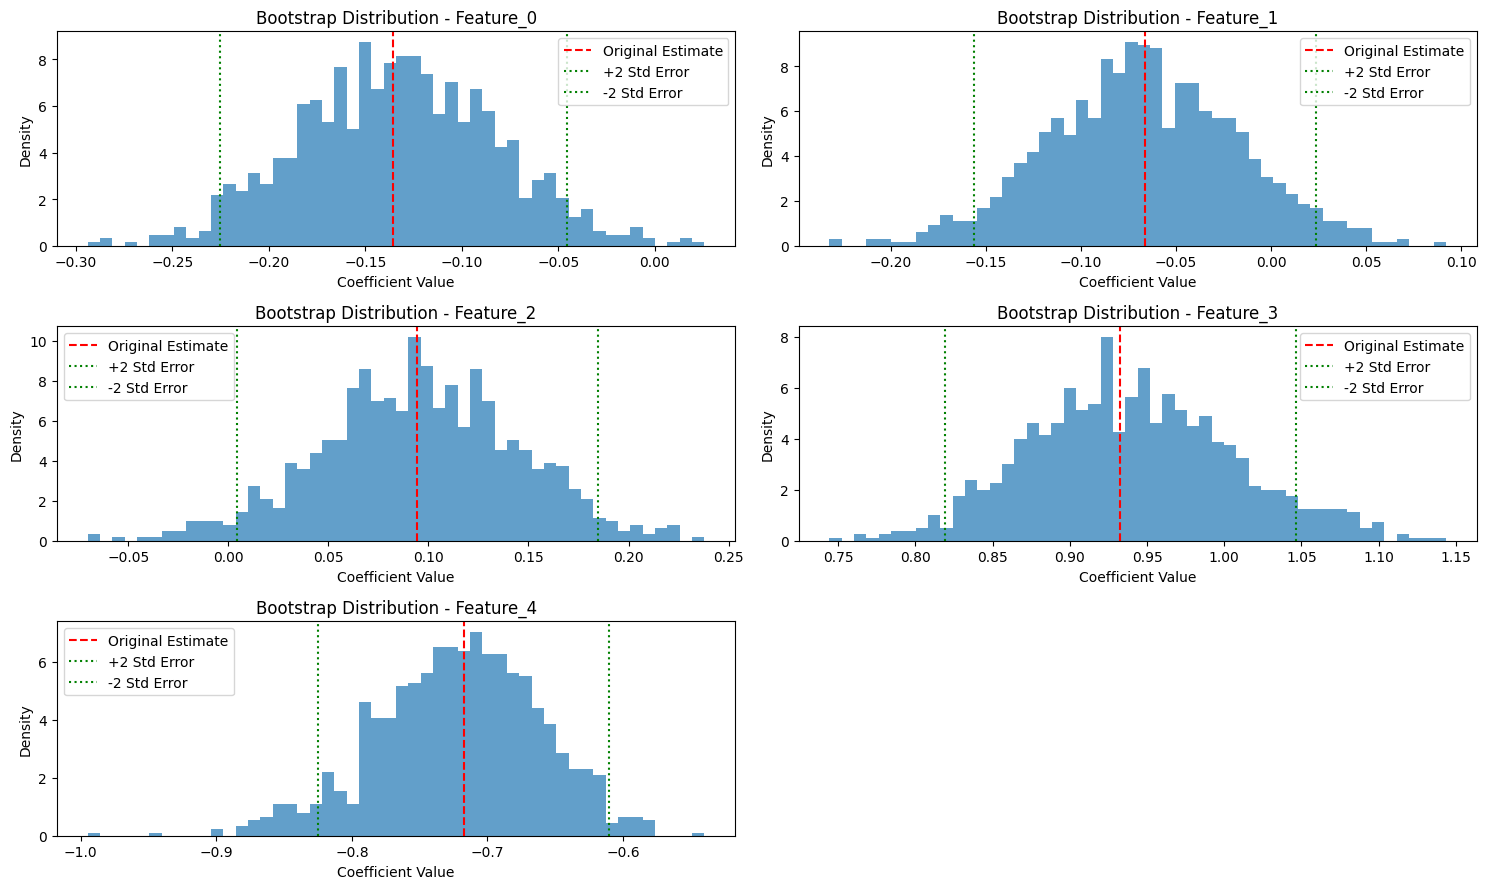


Bootstrap Statistics:

Feature_0:
  Original Estimate: -0.1354
  Original Std Error: 0.0449
  Bootstrap Mean: -0.1334
  Bootstrap Std Error: 0.0510
  95% CI: [-0.2269, -0.0361]

Feature_1:
  Original Estimate: -0.0663
  Original Std Error: 0.0449
  Bootstrap Mean: -0.0676
  Bootstrap Std Error: 0.0500
  95% CI: [-0.1706, 0.0293]

Feature_2:
  Original Estimate: 0.0945
  Original Std Error: 0.0452
  Bootstrap Mean: 0.0955
  Bootstrap Std Error: 0.0494
  95% CI: [-0.0073, 0.1893]

Feature_3:
  Original Estimate: 0.9326
  Original Std Error: 0.0568
  Bootstrap Mean: 0.9403
  Bootstrap Std Error: 0.0662
  95% CI: [0.8193, 1.0793]

Feature_4:
  Original Estimate: -0.7175
  Original Std Error: 0.0536
  Bootstrap Mean: -0.7214
  Bootstrap Std Error: 0.0604
  95% CI: [-0.8513, -0.6163]


In [59]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from jax import grad, hessian
from scipy.optimize import minimize

class ConditionalLogitModel:
    def __init__(self, X, y, feature_names=None):
        """
        Initialize Conditional Logit Model
        
        Parameters:
        - X: 3D numpy array (n_observations, n_alternatives, n_features)
        - y: 2D numpy array of choice indicators (n_observations, n_alternatives)
        - feature_names: Optional list of feature names
        """
        self.X = jnp.array(X)
        self.y = jnp.array(y)
        self.n_obs, self.n_alt, self.n_features = X.shape
        self.feature_names = feature_names or [f'X{i}' for i in range(self.n_features)]
    
    def log_likelihood(self, beta):
        """Compute negative log-likelihood"""
        V = jnp.einsum('ijk,k->ij', self.X, beta)
        exp_V = jnp.exp(V)
        choice_probs = exp_V / jnp.sum(exp_V, axis=1, keepdims=True)
        
        eps = 1e-15
        log_probs = jnp.log(choice_probs + eps)
        return -jnp.sum(self.y * log_probs)
    
    def fit_with_inference(self):
        """Fit model and compute statistical inference"""
        initial_guess = jnp.zeros(self.n_features)
        
        objective = lambda beta: float(self.log_likelihood(beta))
        grad_func = grad(self.log_likelihood)
        hess_func = hessian(self.log_likelihood)
        
        # Use L-BFGS-B method
        result = minimize(
            objective, 
            initial_guess, 
            method='L-BFGS-B', 
            jac=lambda beta: np.array(grad_func(beta)),
            options={'gtol': 1e-8}
        )
        
        beta_hat = result.x
        
        try:
            hessian_matrix = hess_func(beta_hat)
            vcov = np.linalg.inv(hessian_matrix)
            
            std_errors = np.sqrt(np.diag(vcov))
            t_stats = beta_hat / std_errors
            
            # Two-sided p-values
            p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=self.n_obs-self.n_features))
            
            # 95% confidence intervals
            ci_lower = beta_hat - stats.t.ppf(0.975, df=self.n_obs-self.n_features) * std_errors
            ci_upper = beta_hat + stats.t.ppf(0.975, df=self.n_obs-self.n_features) * std_errors
            
            # Create results DataFrame
            results_df = pd.DataFrame({
                'Coefficient': self.feature_names,
                'Estimate': beta_hat,
                'Std Error': std_errors,
                't Statistic': t_stats,
                'p Value': p_values,
                '95% CI Lower': ci_lower,
                '95% CI Upper': ci_upper
            })
            
            return {
                'results': results_df,
                'log_likelihood': -result.fun,
                'converged': result.success,
                'beta_hat': beta_hat,
                'std_errors': std_errors
            }
        
        except np.linalg.LinAlgError:
            print("Hessian is not invertible. Cannot compute standard errors.")
            return None
    
    def bootstrap(self, n_bootstrap=1000, bootstrap_proportion=0.8):
        """
        Perform bootstrapping to validate standard errors
        
        Parameters:
        - n_bootstrap: Number of bootstrap resamples
        - bootstrap_proportion: Proportion of original sample to resample
        
        Returns:
        - Dictionary containing bootstrap results and visualization
        """
        # Compute original model estimates
        original_results = self.fit_with_inference()
        if not original_results:
            raise ValueError("Model fitting failed. Cannot perform bootstrap.")
        
        # Prepare bootstrap storage
        bootstrap_estimates = np.zeros((n_bootstrap, self.n_features))
        
        # Perform bootstrapping
        for i in range(n_bootstrap):
            # Resample observations with replacement
            n_bootstrap_obs = int(self.n_obs * bootstrap_proportion)
            bootstrap_indices = np.random.choice(
                self.n_obs, 
                size=n_bootstrap_obs, 
                replace=True
            )
            
            # Create bootstrap sample
            X_bootstrap = self.X[bootstrap_indices]
            y_bootstrap = self.y[bootstrap_indices]
            
            # Fit model on bootstrap sample
            bootstrap_model = ConditionalLogitModel(
                X_bootstrap, 
                y_bootstrap, 
                self.feature_names
            )
            
            bootstrap_fit = bootstrap_model.fit_with_inference()
            if bootstrap_fit:
                bootstrap_estimates[i] = bootstrap_fit['beta_hat']
        
        # Visualize bootstrap distributions
        plt.figure(figsize=(15, 3*((self.n_features+1)//2)))
        
        for j in range(self.n_features):
            plt.subplot(((self.n_features+1)//2), 2, j+1)
            
            # Bootstrap distribution
            plt.hist(
                bootstrap_estimates[:, j], 
                bins=50, 
                density=True, 
                alpha=0.7
            )
            
            # Original estimate
            orig_est = original_results['beta_hat'][j]
            orig_std = original_results['std_errors'][j]
            
            # Compute bootstrap statistics
            bootstrap_mean = np.mean(bootstrap_estimates[:, j])
            bootstrap_std = np.std(bootstrap_estimates[:, j])
            
            # Plot vertical lines
            plt.axvline(
                orig_est, 
                color='r', 
                linestyle='--', 
                label='Original Estimate'
            )
            plt.axvline(
                orig_est + 2 * orig_std, 
                color='g', 
                linestyle=':', 
                label='+2 Std Error'
            )
            plt.axvline(
                orig_est - 2 * orig_std, 
                color='g', 
                linestyle=':', 
                label='-2 Std Error'
            )
            
            plt.title(f'Bootstrap Distribution - {self.feature_names[j]}')
            plt.xlabel('Coefficient Value')
            plt.ylabel('Density')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Compute bootstrap confidence intervals and other statistics
        bootstrap_stats = {
            'original_estimates': original_results['beta_hat'],
            'original_std_errors': original_results['std_errors'],
            'bootstrap_means': np.mean(bootstrap_estimates, axis=0),
            'bootstrap_std_errors': np.std(bootstrap_estimates, axis=0),
            'bootstrap_confidence_intervals': np.percentile(
                bootstrap_estimates, 
                [2.5, 97.5], 
                axis=0
            )
        }
        
        return bootstrap_stats

def generate_synthetic_data(n_obs=1000, n_alt=3, n_features=5, seed=42):
    """Generate synthetic discrete choice data"""
    np.random.seed(seed)
    
    # Generate random features
    X = np.random.randn(n_obs, n_alt, n_features)
    
    # Generate true coefficients
    true_beta = np.random.randn(n_features)
    
    # Compute utilities
    V = np.einsum('ijk,k->ij', X, true_beta)
    exp_V = np.exp(V)
    probs = exp_V / np.sum(exp_V, axis=1, keepdims=True)
    
    # Simulate choices
    y = np.zeros((n_obs, n_alt))
    for i in range(n_obs):
        y[i, np.random.choice(n_alt, p=probs[i])] = 1
    
    return X, y, true_beta

def main(
    n_obs=1000,   # Sample size
    n_alt=3,      # Number of alternatives
    n_features=5, # Number of features
    seed=42       # Random seed
):
    """Main function to demonstrate Conditional Logit Model with Bootstrap"""
    # Generate synthetic data
    X, y, true_beta = generate_synthetic_data(
        n_obs=n_obs, 
        n_alt=n_alt, 
        n_features=n_features, 
        seed=seed
    )
    
    # Print dataset information
    print("Dataset Information:")
    print(f"Sample Size: {n_obs}")
    print(f"Number of Alternatives: {n_alt}")
    print(f"Number of Features: {n_features}")
    print("True Coefficients:", true_beta)
    
    # Feature names
    feature_names = [f'Feature_{i}' for i in range(n_features)]
    
    # Instantiate and fit model
    model = ConditionalLogitModel(X, y, feature_names)
    
    # Fit with inference
    results = model.fit_with_inference()
    
    if results:
        print("\nModel Estimation Results:")
        print(results['results'].to_string(index=False))
        print(f"\nLog-Likelihood: {results['log_likelihood']}")
        print(f"Convergence: {'Successful' if results['converged'] else 'Failed'}")
        
        # Perform bootstrapping
        print("\nPerforming Bootstrap Validation...")
        bootstrap_results = model.bootstrap(n_bootstrap=1000)
        
        # Print bootstrap statistics
        print("\nBootstrap Statistics:")
        for i, feature in enumerate(feature_names):
            print(f"\n{feature}:")
            print(f"  Original Estimate: {bootstrap_results['original_estimates'][i]:.4f}")
            print(f"  Original Std Error: {bootstrap_results['original_std_errors'][i]:.4f}")
            print(f"  Bootstrap Mean: {bootstrap_results['bootstrap_means'][i]:.4f}")
            print(f"  Bootstrap Std Error: {bootstrap_results['bootstrap_std_errors'][i]:.4f}")
            print(f"  95% CI: [{bootstrap_results['bootstrap_confidence_intervals'][0,i]:.4f}, {bootstrap_results['bootstrap_confidence_intervals'][1,i]:.4f}]")

# Run the main function
if __name__ == "__main__":
    main()

# Alternative Specific Effects

The **Conditional Logit Model (CLM)** models the probability of choosing alternative \( j \) based on its utility \( V_{ij} \), specified as:

$$
V_{ij} = \text{ASC}_j + \beta_\text{time} \cdot \text{time}_{ij} + \beta_\text{cost} \cdot \text{cost}_{ij}
$$

- **Car (Baseline):** $ V_\text{car} = \beta_\text{time} \cdot \text{time}_\text{car} + \beta_\text{cost} \cdot \text{cost}_\text{car} $
- **Bus:** $ V_\text{bus} = \text{asc}_\text{bus} + \beta_\text{time} \cdot \text{time}_\text{bus} + \beta_\text{cost} \cdot \text{cost}_\text{bus} $
- **Metro:** $ V_\text{metro} = \text{asc}_\text{metro} + \beta_\text{time} \cdot \text{time}_\text{metro} + \beta_\text{cost} \cdot \text{cost}_\text{metro} $

The probability of choosing alternative $ j $ is:

$$
P_{ij} = \frac{e^{V_{ij}}}{\sum_k e^{V_{ik}}}
$$

In [86]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import scipy.stats as stats
from jax import grad, hessian
from scipy.optimize import minimize
from typing import Dict, Optional

class ConditionalLogitModel:
    def __init__(
        self,
        df: pd.DataFrame,
        id_col: str,
        choice_col: str,
        alt_col: str,
        time_col: str,
        cost_col: str
    ):
        """
        Conditional Logit Model with:
        - asc_bus, asc_metro, beta_time, beta_cost

        Alternatives: car, bus, metro
        Car is baseline (no asc_car).

        Parameters (4 total):
        [asc_bus, asc_metro, beta_time, beta_cost]
        """
        self.id_col = id_col
        self.choice_col = choice_col
        self.alt_col = alt_col
        self.time_col = time_col
        self.cost_col = cost_col

        # We expect exactly these three alternatives
        alternatives = ['car', 'bus', 'metro']
        if set(df[alt_col].unique()) != set(alternatives):
            raise ValueError("Data must contain exactly 'car', 'bus', and 'metro' alternatives.")

        self.alternatives = alternatives
        self.n_alt = len(alternatives)  # 3
        self.n_features = 4  # asc_bus, asc_metro, beta_time, beta_cost

        # Define 'alt' as categorical with ordered categories
        df = df.copy()
        df['alt'] = pd.Categorical(df[alt_col], categories=alternatives, ordered=True)
        df = df.sort_values([id_col, alt_col])

        self.n_obs = df[id_col].nunique()

        # Reshape choice into (n_obs, n_alt)
        y = df[choice_col].values.reshape(self.n_obs, self.n_alt)

        # Reshape time and cost into (n_obs, n_alt)
        time_wide = df[time_col].values.reshape(self.n_obs, self.n_alt)
        cost_wide = df[cost_col].values.reshape(self.n_obs, self.n_alt)

        self.y = jnp.array(y)
        self.time = jnp.array(time_wide)
        self.cost = jnp.array(cost_wide)

    def log_likelihood(self, beta: jnp.ndarray) -> float:
        """
        Compute the negative log-likelihood.

        beta = [asc_bus, asc_metro, beta_time, beta_cost]

        Utilities:
        V_car = 0 + beta_time * time_car + beta_cost * cost_car
        V_bus = asc_bus + beta_time * time_bus + beta_cost * cost_bus
        V_metro = asc_metro + beta_time * time_metro + beta_cost * cost_metro
        """
        asc_bus = beta[0]
        asc_metro = beta[1]
        beta_time = beta[2]
        beta_cost = beta[3]

        # Compute utilities for each alternative
        V_car = 0.0 + beta_time * self.time[:, 0] + beta_cost * self.cost[:, 0]
        V_bus = asc_bus + beta_time * self.time[:, 1] + beta_cost * self.cost[:, 1]
        V_metro = asc_metro + beta_time * self.time[:, 2] + beta_cost * self.cost[:, 2]

        V = jnp.stack([V_car, V_bus, V_metro], axis=1)

        maxV = jnp.max(V, axis=1, keepdims=True)
        exp_V = jnp.exp(V - maxV)
        denom = jnp.sum(exp_V, axis=1, keepdims=True)
        choice_probs = exp_V / denom

        eps = 1e-15
        log_probs = jnp.log(choice_probs + eps)
        ll = jnp.sum(self.y * log_probs)

        return -ll

    def fit_with_inference(self) -> Optional[Dict]:
        initial_guess = jnp.zeros(self.n_features)
        grad_func = grad(self.log_likelihood)
        hess_func = hessian(self.log_likelihood)

        def objective(beta):
            return float(self.log_likelihood(beta))

        result = minimize(
            fun=objective,
            x0=np.array(initial_guess),
            method='L-BFGS-B',
            jac=lambda beta: np.array(grad_func(jnp.array(beta))),
            options={'gtol': 1e-8, 'maxiter': 1000}
        )

        if not result.success:
            print("Optimization failed!")
            return None

        beta_hat = result.x

        try:
            hessian_matrix = hess_func(jnp.array(beta_hat))
            vcov = np.linalg.inv(np.array(hessian_matrix))
            std_errors = np.sqrt(np.diag(vcov))
            t_stats = beta_hat / std_errors
            df = self.n_obs - len(beta_hat)
            p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=df))
            ci_lower = beta_hat - stats.t.ppf(0.975, df=df) * std_errors
            ci_upper = beta_hat + stats.t.ppf(0.975, df=df) * std_errors

            param_names = ['asc_bus', 'asc_metro', 'beta_time', 'beta_cost']
            results_df = pd.DataFrame({
                'Coefficient': param_names,
                'Estimate': beta_hat,
                'Std Error': std_errors,
                't Statistic': t_stats,
                'p Value': p_values,
                '95% CI Lower': ci_lower,
                '95% CI Upper': ci_upper
            })

            return {
                'results': results_df,
                'log_likelihood': -result.fun,
                'converged': result.success,
                'beta_hat': beta_hat,
                'std_errors': std_errors
            }

        except np.linalg.LinAlgError:
            print("Hessian is not invertible. Cannot compute standard errors.")
            return None


def fit_conditional_logit(
    df: pd.DataFrame,
    id_col: str = 'id',
    choice_col: str = 'choice',
    alt_col: str = 'alt',
    time_col: str = 'time',
    cost_col: str = 'cost'
) -> Dict:
    """
    A reusable function that fits the conditional logit model defined above.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format data with one row per individual-alternative observation.
    id_col : str
        Column name indicating individual IDs.
    choice_col : str
        Column name indicating chosen alternative (1 if chosen, 0 otherwise).
    alt_col : str
        Column name indicating the alternative name.
    time_col : str
        Column name for the time variable.
    cost_col : str
        Column name for the cost variable.

    Returns
    -------
    Dict
        A dictionary containing estimation results and statistics.
    """

    model = ConditionalLogitModel(
        df=df,
        id_col=id_col,
        choice_col=choice_col,
        alt_col=alt_col,
        time_col=time_col,
        cost_col=cost_col
    )
    results = model.fit_with_inference()

    if results is None:
        raise RuntimeError("Model fitting failed.")

    return results


# Example usage with synthetic data:
df, true_params = generate_synthetic_long_data(n_obs=5000)
results = fit_conditional_logit(df, id_col='id', choice_col='choice', alt_col='alt', time_col='time', cost_col='cost')
display(results['results'])

Generating synthetic data...
Generated data sample:
   id    alt      time      cost  choice
0   0    car  0.496714 -0.143423       0
1   0    bus -0.138264 -0.032656       0
2   0  metro  0.647689  0.064295       1
3   1    car  1.523030  0.946861       0
4   1    bus -0.234153 -0.747217       0


,Coefficient,Estimate,Std Error,t Statistic,p Value,95% CI Lower,95% CI Upper
0,asc_bus,0.190172,0.037375,5.088201,3.747152e-07,0.116900,0.263444
1,asc_metro,0.405416,0.035822,11.317601,0.000000e+00,0.335190,0.475642
2,beta_time,-0.326304,0.018247,-17.882414,0.000000e+00,-0.362076,-0.290531
3,beta_cost,0.104832,0.017894,5.858488,4.970063e-09,0.069752,0.139912


In [89]:
import pandas as pd
df = pd.read_csv("https://raw.github.com/arteagac/xlogit/master/examples/data/fishing_long.csv")
df.head()

,id,alt,choice,income,price,catch
0,1,beach,0,7083.3317,157.930,0.0678
1,1,boat,0,7083.3317,157.930,0.2601
2,1,charter,1,7083.3317,182.930,0.5391
3,1,pier,0,7083.3317,157.930,0.0503
4,2,beach,0,1249.9998,15.114,0.1049
